In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
#Loading training set into dataframe
df = pd.read_excel('./data/gang_toc_train.xlsx')
df.head()

,井名,Depth,GR,AC,CNL,DEN,RT,RXO,TOC
0,龙会4,4384.250,59.898,51.739,2.986,2.730,NaN,NaN,0.095
1,龙会4,4379.500,60.681,51.564,2.656,2.723,NaN,NaN,0.143
2,龙会4,4386.875,124.560,53.859,3.956,2.625,NaN,NaN,0.143
3,峰探1,4584.500,40.030,50.546,6.603,2.654,1109.175,951.854,0.150
4,龙会4,4378.125,63.343,57.818,4.362,2.694,NaN,NaN,0.190


In [4]:
df = df.drop(columns='井名')
df = df.drop(columns='Depth')

In [5]:
#This is an example, taking TOC as label to predict
label = df['TOC']
train = df.drop('TOC', axis=1) # we don't need it in this project
label.shape, train.shape

((236,), (236, 6))

In [6]:
#Function to min-max normalize
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [7]:
#Normalizing dataset
new_train = normalize(train,train.columns)
new_train

,GR,AC,CNL,DEN,RT,RXO
0,0.153128,0.100947,0.116017,0.917275,NaN,NaN
1,0.155955,0.096731,0.103722,0.900243,NaN,NaN
2,0.386578,0.152010,0.152155,0.661800,NaN,NaN
3,0.081398,0.072211,0.250773,0.732360,0.101778,0.079420
4,0.165566,0.247369,0.167281,0.829684,NaN,NaN
...,...,...,...,...,...,...
231,0.496177,0.523111,0.401997,0.347932,0.002923,0.002404
232,0.437357,0.616687,0.670057,0.333333,NaN,NaN
233,0.344395,0.744033,0.767594,0.119221,0.000899,0.000494
234,0.216550,0.104873,0.187847,0.822384,0.005154,0.005038


In [8]:
label.isnull().values.any()
new_train.isnull().values.any()

True

In [9]:
#Test Nan and fill with mean
for column in list(new_train.columns[ new_train.isnull().sum() > 0]):
    mean_val = new_train[column].mean()
    new_train[column].fillna(mean_val, inplace=True)

In [10]:
train = np.array(new_train)
label = np.array(label)

In [18]:
train = torch.tensor(train, dtype=torch.float32)
label = torch.tensor(label, dtype=torch.float32)

In [19]:
label.shape, train.shape

(torch.Size([236]), torch.Size([236, 6]))

In [20]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [41]:
class WellLogNet(nn.Module):
    def __init__(self):
        super(WellLogNet, self).__init__()
        self.fc1 = nn.Linear(6, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 6)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class RONet(nn.Module):
    def __init__(self):
        super(RONet, self).__init__()
        self.fc1 = nn.Linear(6, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 6)
        self.fc4 = nn.Linear(6, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class BiasNet(nn.Module):
    def __init__(self):
        super(BiasNet, self).__init__()
        self.fc1 = nn.Linear(6, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class PasseyNet(nn.Module):
    def __init__(self):
        super(PasseyNet, self).__init__()
        self.well_log_net = WellLogNet()
        self.ro_net = RONet()
        self.bias_net = BiasNet()

    def forward(self, x):
        well_log_matrix = self.well_log_net(x)
        ro_matrix = self.ro_net(x)
        bias_matrix = self.bias_net(x)
        
        output = torch.matmul(torch.matmul(x, well_log_matrix.T), 
                              torch.pow(10.0, ro_matrix)) + bias_matrix
        return output

In [72]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error 
from sklearn.model_selection import KFold
from utils.optimizer.sam import SAM
from utils.optimizer.Adam_with_Monmentum import AdamWithMomentum
import torch

torch.autograd.set_detect_anomaly(True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

model = PasseyNet()
model.to(device)

train = train.to(device)
label = label.to(device)

# 定义优化器和损失函数
optimizer = SAM(model.parameters(), AdamWithMomentum)

criterion = nn.MSELoss()

# 存储loss、mae、mse、R2、mape
loss_list = []
mae_list = []
mse_list = []
r2_list = []
r2_adjust_list = []
mape_list = []

for i in range(100):

    kf = KFold(n_splits=5, shuffle=True, random_state=42) # 设置为5-fold

    for fold ,(train_idx, val_idx) in enumerate(kf.split(train)):

        # 划分训练集和验证集
        train_x, train_y = train[train_idx], label[train_idx]
        val_x, val_y = train[val_idx], label[val_idx]

        for epoch in range(100):

            # 训练
            output = model(train)

            output = output.cpu() # 将output移回CPU
            label = label.cpu() # 将label移回CPU
            
            # first forward-backward pass
            loss = criterion(output, label)  
            loss.backward(retain_graph=True)        
            optimizer.first_step(zero_grad=True)

            # second forward-backward pass
            criterion(output, label).backward()  # make sure to do a full forward pass
            optimizer.second_step(zero_grad=True)

            # 更新参数  
            optimizer.step() 

            # 验证
            with torch.no_grad():
                val_output = model(val_x)
                val_output = val_output.cpu()
                val_y = val_y.cpu()
                val_loss = criterion(val_output, val_y)

                val_pred = val_output.detach().numpy()
                val_true = val_y.detach().numpy()

                val_mae = mean_absolute_error(val_true, val_pred)
                val_mse = mean_squared_error(val_true, val_pred)

                val_r2 = r2_score(val_true, val_pred)
                val_mape = mean_absolute_percentage_error(val_true, val_pred)

                val_adjust_r2 = 1-((1-val_r2)*(len(val_x)-1))/(len(val_x)-6-1)

                # 打印结果  
                # print(f'Epoch: {epoch+1:02d}, Loss: {loss:.4f}, R2: {val_r2:.4f}, MAE: {val_mae:.4f}, MSE: {val_mse:.4f}, MAPE: {val_mape:.4f}')
        
            # 存储loss、mae和mse
            loss_list.append(val_loss.item())
            mae_list.append(val_mae)
            mse_list.append(val_mse)
            r2_list.append(val_r2)
            r2_adjust_list.append(val_adjust_r2)
            mae_list.append(val_mape)
    
# 绘制K折验证结果        
plt.plot(loss_list)
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 绘制MAE、MSE、MAPE曲线
plt.plot(mae_list, label='MAE')
plt.plot(mse_list, label='MSE')
plt.plot(mae_list, label='MAE')
plt.title('MAE, MSE, MAPE Curve')  
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

# 绘制R2、R2_adjust曲线
plt.plot(r2_list, label='R2')
plt.plot(r2_adjust_list, label='R2_adjust')
plt.title('R2 & Adjusted R2 Curve')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [64, 1]], which is output 0 of TBackward, is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [89]:
#Loading training set into dataframe
test_df = pd.read_excel('./data/gang_toc_train.xlsx')
test_df.head()

,井名,Depth,GR,AC,CNL,DEN,RT,RXO,TOC
0,龙会4,4384.250,59.898,51.739,2.986,2.730,NaN,NaN,0.095
1,龙会4,4379.500,60.681,51.564,2.656,2.723,NaN,NaN,0.143
2,龙会4,4386.875,124.560,53.859,3.956,2.625,NaN,NaN,0.143
3,峰探1,4584.500,40.030,50.546,6.603,2.654,1109.175,951.854,0.150
4,龙会4,4378.125,63.343,57.818,4.362,2.694,NaN,NaN,0.190


In [90]:
test_df.shape

(236, 9)

In [91]:
test_df_last_30 = test_df.tail(30)
test_df_last_30.shape

(30, 9)

In [93]:
#This is an example, taking TOC as label to predict
test_label = test_df_last_30['TOC']
test_train = test_df_last_30.drop('TOC', axis=1) # we don't need it in this project
test_label.shape, test_train.shape

((30,), (30, 8))

In [94]:
test_train = test_train.drop(columns='井名')
test_train = test_train.drop(columns='Depth')

In [95]:
#Normalizing dataset
normalized_test_train = normalize(test_train, test_train.columns)
normalized_test_train

,GR,AC,CNL,DEN,RT,RXO
206,0.319928,1.000000,NaN,NaN,0.012648,0.014856
207,0.552926,0.821151,0.561310,0.205556,NaN,NaN
208,0.739649,0.652949,0.565255,0.433333,NaN,NaN
209,0.153235,0.202883,0.220882,0.477778,0.883460,0.859600
210,0.639481,0.697490,0.786045,0.391667,NaN,NaN
211,0.055309,0.304838,NaN,NaN,0.091753,0.096249
212,0.354886,0.379198,0.222854,0.641667,0.327671,0.316643
213,0.782641,0.582115,0.339373,0.388889,0.006886,0.011801
214,0.000000,0.119073,NaN,NaN,0.049769,0.036656
215,0.531265,0.609607,0.430524,0.547222,0.184966,0.180032


In [96]:
#Test Nan and fill with mean
for column in list(normalized_test_train.columns[ normalized_test_train.isnull().sum() > 0]):
    mean_val = normalized_test_train[column].mean()
    normalized_test_train[column].fillna(mean_val, inplace=True)

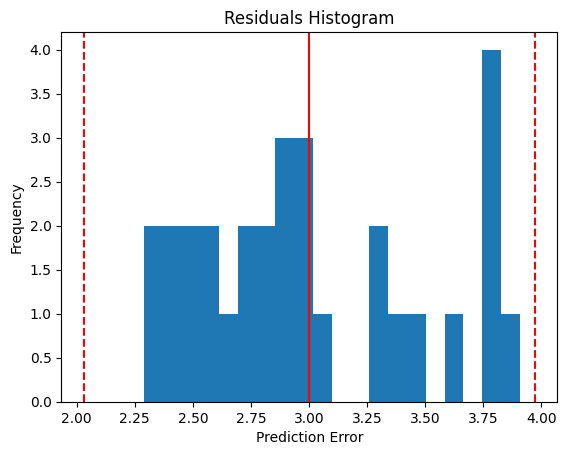

In [97]:
# 需要传入Tensor 
X_test = normalized_test_train.values # 转为numpy数组
X_test = torch.Tensor(X_test).to(device) # 转为Tensor


# 切换到训练模式
model.train() 

# 预测值 
y_pred = model(X_test)
y_pred = y_pred.cpu().detach().numpy()

# 真实值
y_true = test_label 

# 残差 
y_true = y_true.ravel()  
y_pred = y_pred.ravel()
resid = y_true - y_pred

# 绘图
plt.hist(resid, bins=20)
plt.title('Residuals Histogram')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

# 均值和标准差
mean = resid.mean()
stddev = resid.std()

# 绘制竖直线
plt.axvline(mean, color='r')
plt.axvline(mean + 2*stddev, color='r', linestyle='--')
plt.axvline(mean - 2*stddev, color='r', linestyle='--')

plt.show()

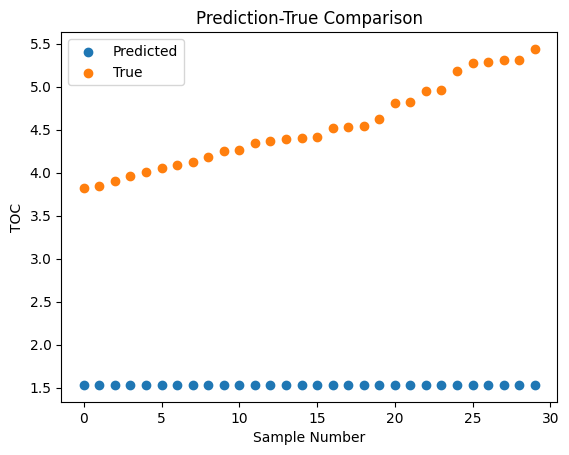

In [99]:
# 绘制预测值实际值差距图

# well_name = test_df_last_30['井名']

x = range(len(y_pred))

plt.scatter(x, y_pred, label='Predicted')
plt.scatter(x, y_true, label='True')

plt.title('Prediction-True Comparison')
plt.ylabel('TOC')
plt.xlabel('Sample Number')
plt.legend()
plt.show()